# **EC1B1 Python Coursework**

## 1: Setting Up The Environment ##


In [1]:
# Data Collection Dictionaries
import pandas as pd
import numpy as np
import requests
import openpyxl
import io

# Data Visualisation Dictionaries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

## Section 4.2 Data Cleaning ##

### 2: Importing Data & Cleaning ###

Spain data:  
(i) Industrial production (Index)  
(ii) Exchange rates, National Currency per US dollar (Period Average)  
(iii) Consumer prices (All items), index  
(iv) International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)  

Note there is no industrial production data for Spain in 1960, treat these as missing values

US data:  
(i) Consumer prices (All items), index  
(ii) International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)

We are retrieving and processing data from two Google Sheets:

*  Spain
*  US

Our code reads the data into Pandas DataFrames, sets the first row as column names, and resets the index. Then, we merge the datasets based on their index, remove duplicate date columns, and rename the remaining date column for clarity. Finally, we convert all numerical columns to the appropriate data type

In [2]:
# Google Sheets URL
spain_url = 'https://docs.google.com/spreadsheets/d/1QphOiaZZHRyJe8vvn3BFCDIrNdvKxhmg/export?format=xlsx'
us_url = 'https://docs.google.com/spreadsheets/d/10Xf4iqrd_kgqtpGmmnyG4l2mtbM8ua_g/export?format=xlsx'

# Fetch the data
response_spain = requests.get(spain_url)
response_spain.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
response_us = requests.get(us_url)
response_us.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

# Convert to DataFrames
spain_data = pd.read_excel(io.BytesIO(response_spain.content), header=0)
us_data = pd.read_excel(io.BytesIO(response_us.content), header=0)

# Set first row as column names
spain_data.columns = spain_data.iloc[0]
spain_data = spain_data[1:].reset_index(drop=True)
us_data.columns = us_data.iloc[0]
us_data = us_data[1:].reset_index(drop=True)

# Merge datasets based on index
merged_data = pd.merge(spain_data, us_data, left_index=True, right_index=True, suffixes=('_Spain', '_US'))

# Drop the repeated date column and rename the remaining one
merged_data = merged_data.drop(columns=['nan_US'])
merged_data = merged_data.rename(columns={'nan_Spain': 'Date'})

# Convert all columns except 'Date' to numeric, coercing errors to NaN
merged_data.iloc[:, 1:] = merged_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
merged_data = merged_data.infer_objects()

# Display merged data
merged_data.head()

,Date,"Economic Activity, Industrial Production, Index","Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_Spain","Prices, Consumer Price Index, All items, Index_Spain","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_US","Prices, Consumer Price Index, All items, Index_US"
0,Dec 1959,NaN,60.0,200.0,2.879972,21504.5,13.482806
1,Jan 1960,NaN,60.0,233.0,2.857368,21478.1,13.436946
2,Feb 1960,NaN,60.0,253.0,2.855049,21395.7,13.482806
3,Mar 1960,NaN,60.0,299.0,2.851573,21344.7,13.482806
4,Apr 1960,NaN,60.0,326.0,2.853891,21278.0,13.528666


### 3: Construct Variables ###


We calculate various economic indicators for Spain and the US using the merged dataset:

* Monthly growth in nominal exchange rate for Spain
* Monthly growth (% change) in real exchange rate for Spain
* Index of the real exchange rate
* Monthly inflation rate (% change) for Spain
* Monthly growth in industrial production (% change) for Spain
* Spain's growth in industrial production compared to 1year ago
* Spain's index of international reserves
* US monthly inflation rate (% change)
* US' index of international reserves

These transformations help analyze currency valuation, inflation trends, and economic activity over time.










In [3]:
# (i) Monthly growth in nominal exchange rate for Spain (percentage change)
merged_data['Spain Nominal Exchange Rate Monthly Growth'] = merged_data['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate'].pct_change() * 100

# Real exchange rate for Spain/US = Nominal exchange rate Spain/US * (CPI_US / CPI_Spain)
merged_data['Spain Real Exchange Rate'] = (
    merged_data['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate'] *
    (
        merged_data['Prices, Consumer Price Index, All items, Index_US'] /
        merged_data['Prices, Consumer Price Index, All items, Index_Spain']
    )
)

# (ii) Monthly growth in real exchange rate for Spain (percentage change)
merged_data['Spain Real Exchange Rate Monthly Growth'] = merged_data['Spain Real Exchange Rate'].pct_change() * 100

# (iii) Index of the real exchange rate (setting the real exchange rate for December 1990 = 1)
dec_1990_value = merged_data.loc[merged_data['Date'] == 'Dec 1990', 'Spain Real Exchange Rate'].iloc[0]
merged_data['Spain Real Exchange Rate Index'] = merged_data['Spain Real Exchange Rate'] / dec_1990_value

# (iv) Monthly inflation rate for Spain (percentage change)
merged_data['Spain Inflation Rate'] = merged_data['Prices, Consumer Price Index, All items, Index_Spain'].pct_change() * 100

# (v) Monthly growth in industrial production for Spain (percentage change)
merged_data['Spain Industrial Production Monthly Growth'] = merged_data['Economic Activity, Industrial Production, Index'].pct_change() * 100

# (vi) Growth in industrial production compared to 12 months ago (percentage change)
merged_data['Spain Industrial Production 12 Month Growth'] = merged_data['Economic Activity, Industrial Production, Index'].pct_change(periods=12) * 100

# (vii) Index of Spain international reserves (January 1960 = 100)
jan_1960_value = merged_data.loc[merged_data['Date'] == 'Jan 1960', 'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_Spain'].iloc[0]
merged_data['Spain International Reserves Index'] = (merged_data['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_Spain'] / jan_1960_value) * 100

# (viii) Monthly inflation rate for US (percentage change)
merged_data['US Inflation Rate'] = merged_data['Prices, Consumer Price Index, All items, Index_US'].pct_change() * 100

# (ix) Index of US international reserves (January 1960 = 100)
jan_1960_value_US = merged_data.loc[merged_data['Date'] == 'Jan 1960', 'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_US'].iloc[0]
merged_data['US International Reserves Index'] = (merged_data['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_US'] / jan_1960_value_US) * 100

# Display the first few rows to check the result
merged_data.head()

,Date,"Economic Activity, Industrial Production, Index","Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_Spain","Prices, Consumer Price Index, All items, Index_Spain","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_US","Prices, Consumer Price Index, All items, Index_US",Spain Nominal Exchange Rate Monthly Growth,Spain Real Exchange Rate,Spain Real Exchange Rate Monthly Growth,Spain Real Exchange Rate Index,Spain Inflation Rate,Spain Industrial Production Monthly Growth,Spain Industrial Production 12 Month Growth,Spain International Reserves Index,US Inflation Rate,US International Reserves Index
0,Dec 1959,NaN,60.0,200.0,2.879972,21504.5,13.482806,NaN,280.894550,NaN,2.561868,NaN,NaN,NaN,85.836910,NaN,100.122916
1,Jan 1960,NaN,60.0,233.0,2.857368,21478.1,13.436946,0.0,282.153680,0.448257,2.573352,-0.784875,NaN,NaN,100.000000,-0.340136,100.000000
2,Feb 1960,NaN,60.0,253.0,2.855049,21395.7,13.482806,0.0,283.346534,0.422768,2.584231,-0.081128,NaN,NaN,108.583691,0.341297,99.616353
3,Mar 1960,NaN,60.0,299.0,2.851573,21344.7,13.482806,0.0,283.691987,0.121919,2.587382,-0.121770,NaN,NaN,128.326180,0.000000,99.378902
4,Apr 1960,NaN,60.0,326.0,2.853891,21278.0,13.528666,0.0,284.425709,0.258633,2.594074,0.081292,NaN,NaN,139.914163,0.340136,99.068353


### 4:  Identify Outliers ###  
We can use the IQR (Interquartile Range) method, which is effective for detecting implausibly extreme values that don't fit with the majority of the data.

In [4]:
# Function to identify and count outliers using the IQR method
def detect_and_replace_outliers(df, column_name):
    # Check if the column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_condition = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)

    # Count the outliers
    outlier_count = outliers_condition.sum()

    # Replace outliers with NaN
    df[column_name] = df[column_name].where(~outliers_condition, np.nan)

    return outlier_count

# Dictionary to store the number of outliers for each column
outlier_counts = {}

# List of columns to check for outliers
outlier_columns = [
    'Spain Nominal Exchange Rate Monthly Growth',
    'Spain Real Exchange Rate',
    'Spain Real Exchange Rate Monthly Growth',
    'Spain Real Exchange Rate Index',
    'Spain Inflation Rate',
    'Spain Industrial Production Monthly Growth',
    'Spain Industrial Production 12 Month Growth',
    'Spain International Reserves Index',
    'US Inflation Rate',
    'US International Reserves Index'
]

# Iterate through the columns, detect outliers, replace with NaN, and store outlier count
total_outliers = 0  # Initialize a counter for total outliers

for col in outlier_columns:
    outlier_count = detect_and_replace_outliers(merged_data, col)
    outlier_counts[col] = outlier_count
    total_outliers += outlier_count  # Add to the total count of outliers

# Print the number of outliers detected
print("Total number of outliers detected:", total_outliers)

# Display the outlier counts for each column
print("\nOutliers per column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

Total number of outliers detected: 269

Outliers per column:
Spain Nominal Exchange Rate Monthly Growth: 107 outliers
Spain Real Exchange Rate: 0 outliers
Spain Real Exchange Rate Monthly Growth: 37 outliers
Spain Real Exchange Rate Index: 0 outliers
Spain Inflation Rate: 7 outliers
Spain Industrial Production Monthly Growth: 45 outliers
Spain Industrial Production 12 Month Growth: 2 outliers
Spain International Reserves Index: 38 outliers
US Inflation Rate: 14 outliers
US International Reserves Index: 19 outliers


### 5: Improvement of method ###
We observed a significant number of outliers, particularly in the 'Spain Nominal Exchange Rate Monthly Growth' series. Upon further inspection of the data, it became clear that these outliers were likely driven by an underlying trend, which was not adequately accounted for by the IQR method. The IQR method applies a fixed threshold to all data points, which can flag points as outliers even if they are part of a broader trend.

To address this issue, we switched to a more dynamic approach by applying a rolling window. This approach allows us to compute a moving average (trend) and detect deviations from it. By focusing on local changes rather than applying a blanket rule across the entire dataset, this method becomes more sensitive to short-term fluctuations and can better capture true outliers without being influenced by long-term trends.

In [5]:
def detect_and_replace_outliers_z_score(df, column_name, window=12, threshold=3):
    # Calculate the rolling mean and standard deviation
    rolling_mean = df[column_name].rolling(window=window).mean()
    rolling_std = df[column_name].rolling(window=window).std()

    # Calculate the Z-score
    z_scores = (df[column_name] - rolling_mean) / rolling_std

    # Flag outliers (Z-score > threshold or Z-score < -threshold)
    outliers_z_score = z_scores.abs() > threshold

    # Replace outliers with NaN using .loc to avoid SettingWithCopyWarning
    df.loc[outliers_z_score, column_name] = np.nan

    # Return the number of outliers detected
    return outliers_z_score.sum()

# List of columns you want to check for outliers using the Z-score method
outlier_columns = [
    'Spain Nominal Exchange Rate Monthly Growth',
    'Spain Real Exchange Rate',
    'Spain Real Exchange Rate Monthly Growth',
    'Spain Real Exchange Rate Index',
    'Spain Inflation Rate',
    'Spain Industrial Production Monthly Growth',
    'Spain Industrial Production 12 Month Growth',
    'Spain International Reserves Index',
    'US Inflation Rate',
    'US International Reserves Index'
]

# Initialize a dictionary to store the number of outliers for each column
outlier_counts = {}
total_outliers = 0  # Initialize a counter for total outliers

# Loop through each column to detect and replace outliers
for col in outlier_columns:
    outlier_count = detect_and_replace_outliers_z_score(merged_data, col)
    outlier_counts[col] = outlier_count
    total_outliers += outlier_count  # Add to the total count of outliers

# Print the number of outliers detected in each column and the total count
for col, count in outlier_counts.items():
    print(f"Number of outliers in '{col}': {count}")

print(f"Total number of outliers: {total_outliers}")

Number of outliers in 'Spain Nominal Exchange Rate Monthly Growth': 1
Number of outliers in 'Spain Real Exchange Rate': 1
Number of outliers in 'Spain Real Exchange Rate Monthly Growth': 0
Number of outliers in 'Spain Real Exchange Rate Index': 1
Number of outliers in 'Spain Inflation Rate': 0
Number of outliers in 'Spain Industrial Production Monthly Growth': 0
Number of outliers in 'Spain Industrial Production 12 Month Growth': 0
Number of outliers in 'Spain International Reserves Index': 0
Number of outliers in 'US Inflation Rate': 0
Number of outliers in 'US International Reserves Index': 1
Total number of outliers: 4


## Section 4.3 End Product ##

### 6: Interpolate missing data ###  
Since there is no industrial production data for Spain in 1960, we replace the missing values with the earliest available data from January 1961, rather than using interpolation with the mean, which would result in inaccurate estimates.

For each series, replace any gaps in the data (including the data you set to missing because they were outliers) with the mean of the value of the series before and after the gap. For example, if the measure of inflation is missing for January 1965, replace the value of inflation with the mean of inflation in December 1964 and February 1965.

In [6]:
# Format the month and year variable into a date format
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%b %Y', errors='coerce')

# Get the value of Industrial Production in Jan 1961 as a scalar (single value)
jan_1961_value = merged_data.loc[merged_data['Date'] == 'Jan 1961', 'Economic Activity, Industrial Production, Index'].iloc[0]

# Assign Jan 1961 value to missing values in Dec 1959 to Dec 1960 period
mask = (merged_data['Date'] >= 'Dec 1959') & (merged_data['Date'] <= 'Dec 1960')
merged_data.loc[mask, 'Economic Activity, Industrial Production, Index'] = jan_1961_value

# Recalculate the Industrial Production growth (monthly and 12-month growth)
merged_data['Spain Industrial Production Monthly Growth'] = merged_data['Economic Activity, Industrial Production, Index'].pct_change() * 100
merged_data['Spain Industrial Production 12 Month Growth'] = merged_data['Economic Activity, Industrial Production, Index'].pct_change(periods=12) * 100

# Function to interpolate missing data (including NaNs from outliers)
def interpolate_missing_data(df, column_name):
    # Interpolate missing values by taking the mean of previous and next values
    df[column_name] = df[column_name].interpolate(method='linear', limit_direction='both')
    return df

# Interpolate missing data for each column
for col in outlier_columns:
    merged_data = interpolate_missing_data(merged_data, col)

# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Print the entire dataset
print(merged_data)

pd.reset_option('display.max_rows')

0         Date  Economic Activity, Industrial Production, Index  \
0   1959-12-01                                        18.687510   
1   1960-01-01                                        18.687510   
2   1960-02-01                                        18.687510   
3   1960-03-01                                        18.687510   
4   1960-04-01                                        18.687510   
5   1960-05-01                                        18.687510   
6   1960-06-01                                        18.687510   
7   1960-07-01                                        18.687510   
8   1960-08-01                                        18.687510   
9   1960-09-01                                        18.687510   
10  1960-10-01                                        18.687510   
11  1960-11-01                                        18.687510   
12  1960-12-01                                        18.687510   
13  1961-01-01                                        18.68751

## Section 5.2.1 Exchange Rate and International Reserve Graphs ##

### 7: Exchange Rate Graphs ###

We now visualise key exchange rate dynamics for Spain. We remove the December 1959 row for data consistency and display 4 subplots:
1. Monthly growth in Spain’s nominal exchange rate
2. Level of the nominal exchange rate
3. Monthly growth in the real exchange rate
4. Index of Spain's real exchange rate.

A vertical dashed red line marks Spain’s departure from the Bretton Woods system in August 1971

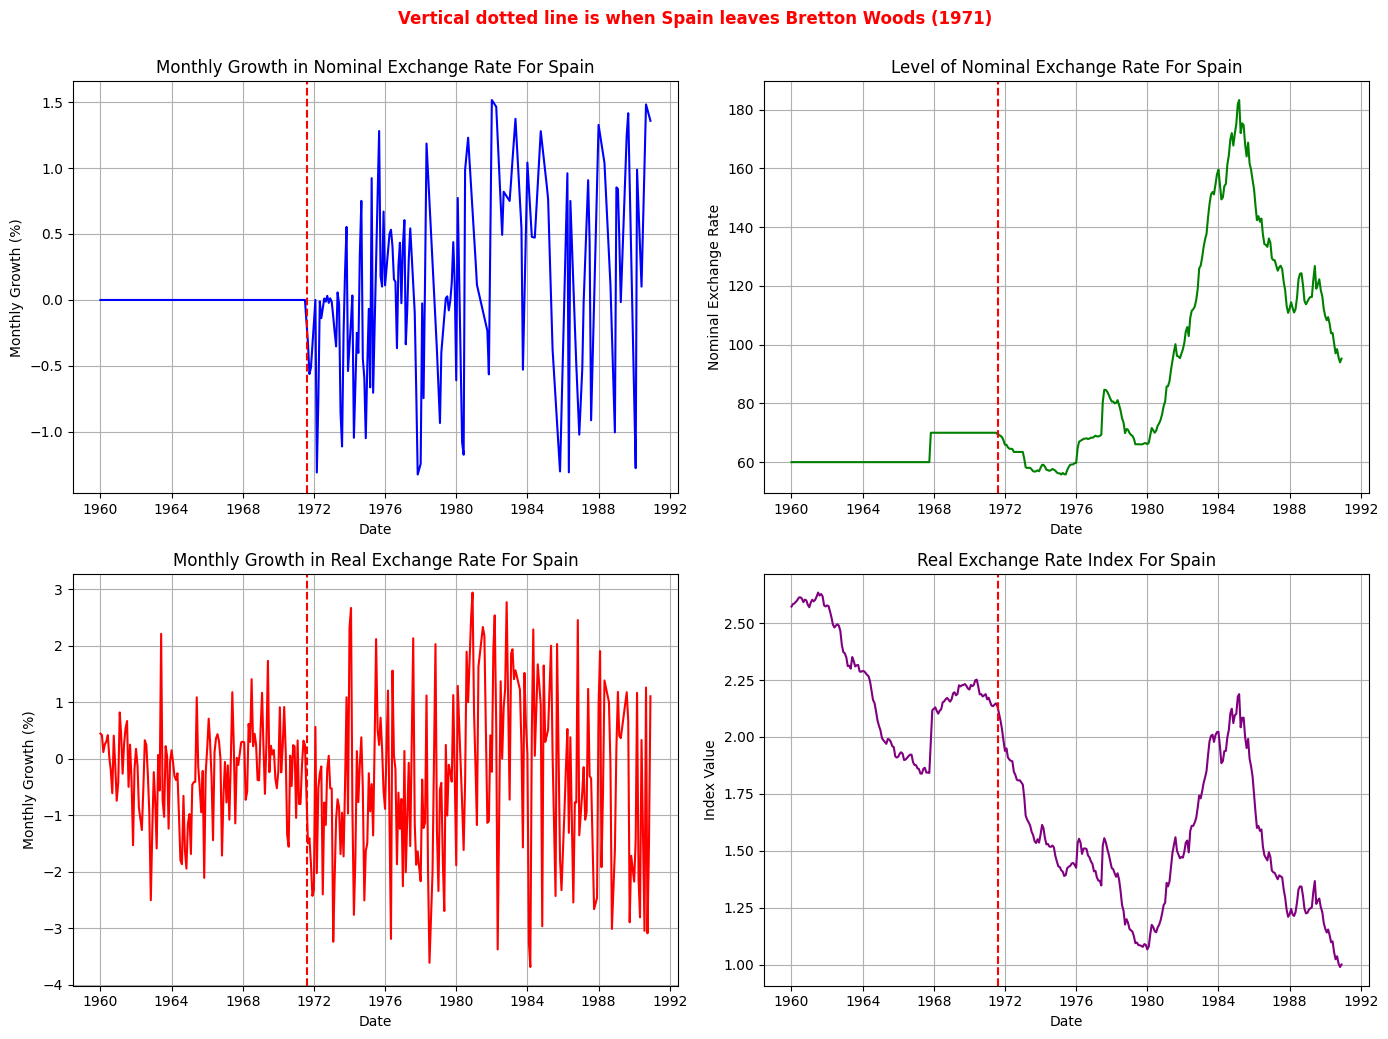

In [7]:
# Drop the December 1959 row
merged_data = merged_data[merged_data['Date'] != '1959-12-01']

# Set up the figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (i) Monthly growth in the nominal exchange rate
axes[0, 0].plot(merged_data['Date'], merged_data['Spain Nominal Exchange Rate Monthly Growth'], label='Spain Monthly Growth', color='blue')
axes[0, 0].set_title('Monthly Growth in Nominal Exchange Rate For Spain')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Monthly Growth (%)')
axes[0, 0].grid(True)

# (ii) The level of the nominal exchange rate
axes[0, 1].plot(merged_data['Date'], merged_data['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate'], label='Nominal Exchange Rate', color='green')
axes[0, 1].set_title('Level of Nominal Exchange Rate For Spain')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Nominal Exchange Rate')
axes[0, 1].grid(True)

# (iii) Monthly growth in the real exchange rate
axes[1, 0].plot(merged_data['Date'], merged_data['Spain Real Exchange Rate Monthly Growth'], label='Spain Real Exchange Rate Monthly Growth', color='red')
axes[1, 0].set_title('Monthly Growth in Real Exchange Rate For Spain')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Monthly Growth (%)')
axes[1, 0].grid(True)

# (iv) Real exchange rate index
axes[1, 1].plot(merged_data['Date'], merged_data['Spain Real Exchange Rate Index'], label='Spain Real Exchange Rate Index', color='purple')
axes[1, 1].set_title('Real Exchange Rate Index For Spain')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Index Value')
axes[1, 1].grid(True)

# Date when Spain left the Bretton Woods system (1971)
departure_date = pd.to_datetime('1971-08-15')

# Add the vertical line for the departure date on all subplots
for ax in axes.flatten():
    ax.axvline(pd.to_datetime(departure_date), color='red', linestyle='--')

fig.text(0.5, 1.025, 'Vertical dotted line is when Spain leaves Bretton Woods (1971)', ha='center', va='center', color='red', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 8: International Reserve Graphs ###

We are filtering the dataset to include only dates up to August 1971, the point at which Spain exited the Bretton Woods system. We then created a line plot comparing the indexed international reserves of Spain and the US, with January 1960 as the base (100).

The graph provides a clear visualisation of how international reserves evolved in both countries before the system's collapse.

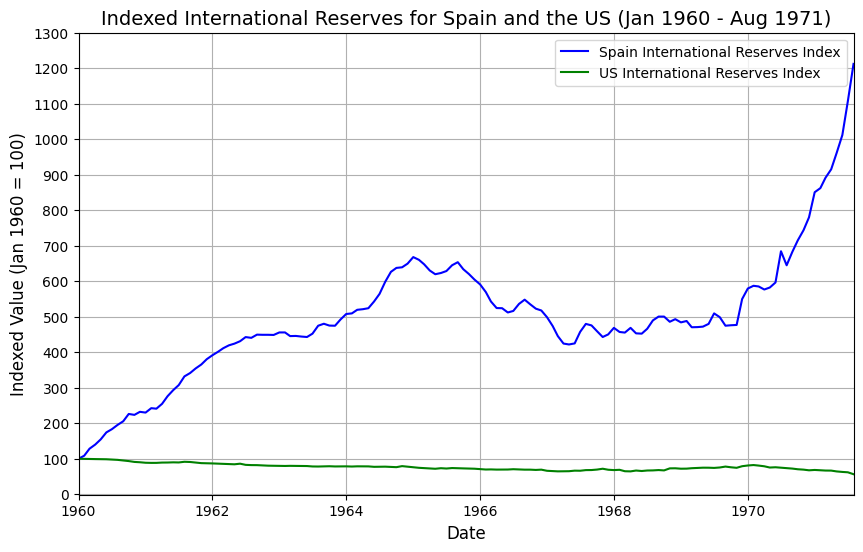

In [8]:
# Filter the data to include only dates until August 1971 (exit from Bretton Woods)
merged_data_bretton_woods = merged_data[(merged_data['Date'] <= '1971-08-15')]

# Plot the graphs
fig, axes = plt.subplots(figsize=(10, 6))

# Plot indexed international reserves for Spain
axes.plot(merged_data_bretton_woods['Date'], merged_data_bretton_woods['Spain International Reserves Index'], label='Spain International Reserves Index', color='blue')

# Plot indexed international reserves for the US
axes.plot(merged_data_bretton_woods['Date'], merged_data_bretton_woods['US International Reserves Index'], label='US International Reserves Index', color='green')

# Set the title and labels
axes.set_title('Indexed International Reserves for Spain and the US (Jan 1960 - Aug 1971)', fontsize=14)
axes.set_xlabel('Date', fontsize=12)
axes.set_ylabel('Indexed Value (Jan 1960 = 100)', fontsize=12)
axes.grid(True)

# Set x-axis limits to remove extra space on the sides
axes.set_xlim([merged_data_bretton_woods['Date'].min(), merged_data_bretton_woods['Date'].max()])

# # Set y-axis ticks to display every 100th data point
axes.set_yticks(range(0, int(merged_data_bretton_woods[['Spain International Reserves Index', 'US International Reserves Index']].max().max()) + 100, 100))

axes.legend()
plt.show()

 ## Section 5.2.2 Inflation and Industrial Production Graphs ##

### 9:  Inflation and Industrial Production Graphs ###

We then analyse inflation and industrial production trends in Spain and the US.
1. Our 1st plot compares the monthly inflation rates of both countries.
2. Our 2nd plot shows the difference between Spain’s and the US’s inflation.
3. Our 3rd plot visualises Spain’s monthly industrial production growth.
4. Our 4th plot tracks its year-over-year industrial production growth.

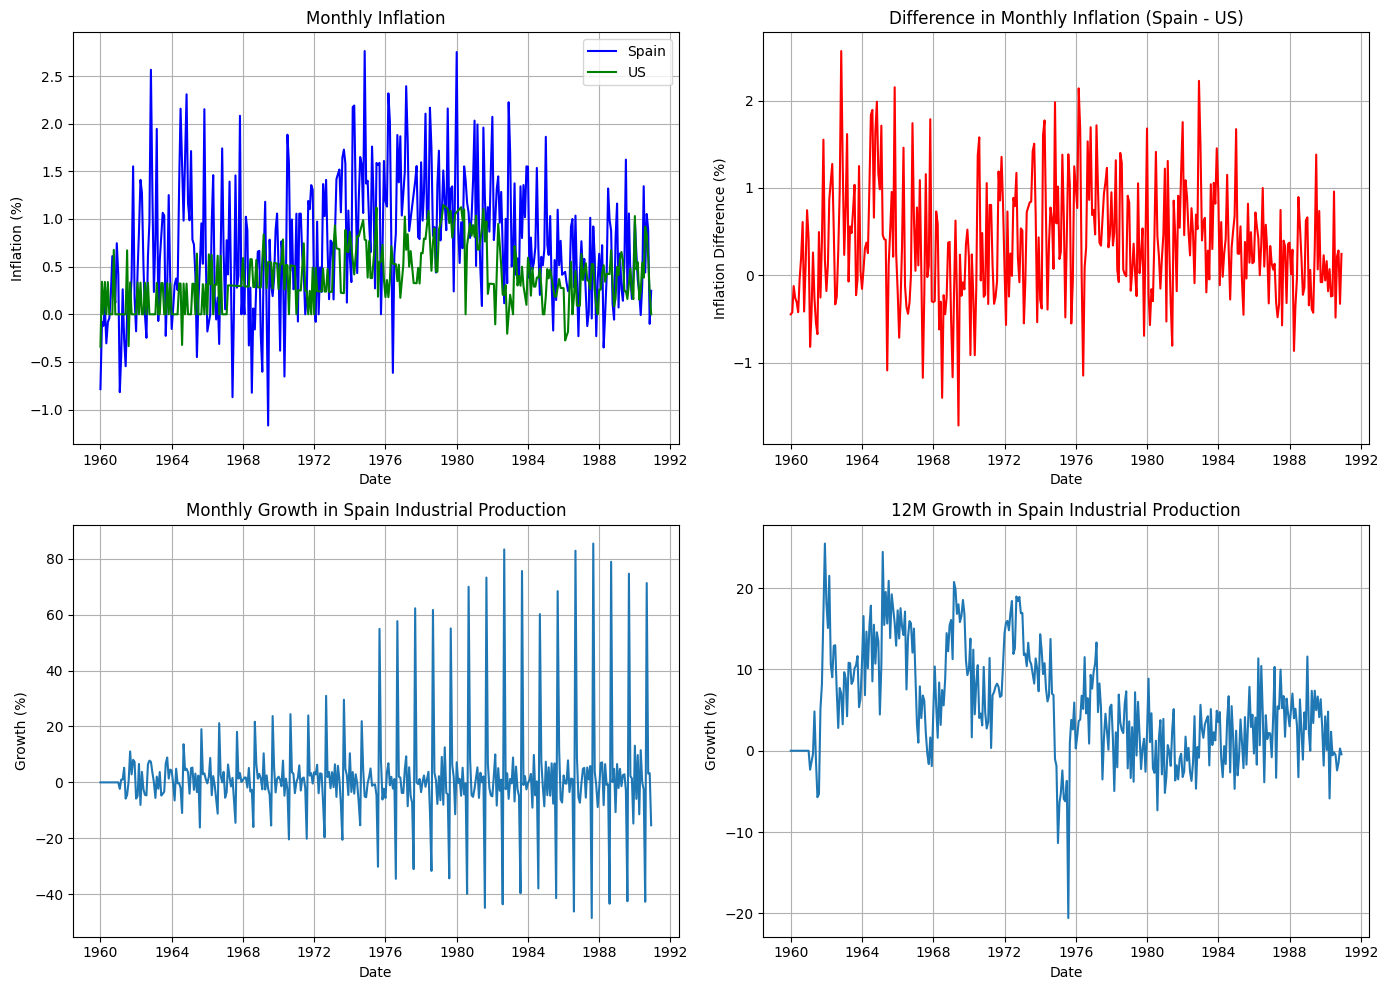

In [9]:
# Set up the figure with two subplots (one for inflation, one for industrial production)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (i) Monthly inflation
axes[0, 0].plot(merged_data['Date'], merged_data['Spain Inflation Rate'], label='Spain', color='blue')
axes[0, 0].plot(merged_data['Date'], merged_data['US Inflation Rate'], label='US', color='green')
axes[0, 0].set_title('Monthly Inflation')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Inflation (%)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# (ii) Difference in monthly inflation (Spain - US)
merged_data['Difference in Monthly Inflation'] = merged_data['Spain Inflation Rate'] - merged_data['US Inflation Rate']
axes[0, 1].plot(merged_data['Date'], merged_data['Difference in Monthly Inflation'], color='red')
axes[0, 1].set_title('Difference in Monthly Inflation (Spain - US)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Inflation Difference (%)')
axes[0, 1].grid(True)

# (iii) Monthly growth in industrial production
axes[1, 0].plot(merged_data['Date'], merged_data['Spain Industrial Production Monthly Growth'])
axes[1, 0].set_title('Monthly Growth in Spain Industrial Production')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Growth (%)')
axes[1, 0].grid(True)

# (iv) Growth in industrial production versus 12 months ago
axes[1, 1].plot(merged_data['Date'], merged_data['Spain Industrial Production 12 Month Growth'])
axes[1, 1].set_title('12M Growth in Spain Industrial Production')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Growth (%)')
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Section 5.2.3 Comparison Statistics & Visualisation ##

### 10: Comparison Statistics & Visualisation ###

In [10]:
# Filter for Before and After Bretton Woods
before_bretton_woods = merged_data[merged_data['Date'] <= '1971-06']
after_bretton_woods = merged_data[merged_data['Date'] >= '1973-03']

# Variables for Standard Deviation Calculation
variables = [
    'Spain Nominal Exchange Rate Monthly Growth',
    'Spain Real Exchange Rate Monthly Growth',
    'Spain Inflation Rate',
    'Difference in Monthly Inflation',
    'Spain Industrial Production 12 Month Growth'
]

# Calculate Standard Deviations
std_before = before_bretton_woods[variables].std()
std_after = after_bretton_woods[variables].std()

# Calculate Ratios
std_ratio = std_before / std_after

# Combine Results in a DataFrame
std_table = pd.DataFrame({
    'SD Before Bretton Woods': std_before,
    'SD After Bretton Woods': std_after,
    'Ratio (Before/After)': std_ratio
})

# Display Results
print(std_table)

                                             SD Before Bretton Woods  \
0                                                                      
Spain Nominal Exchange Rate Monthly Growth                  0.000000   
Spain Real Exchange Rate Monthly Growth                     0.771088   
Spain Inflation Rate                                        0.702702   
Difference in Monthly Inflation                             0.760784   
Spain Industrial Production 12 Month Growth                 6.738439   

                                             SD After Bretton Woods  \
0                                                                     
Spain Nominal Exchange Rate Monthly Growth                 0.708779   
Spain Real Exchange Rate Monthly Growth                    1.525917   
Spain Inflation Rate                                       0.620779   
Difference in Monthly Inflation                            0.616345   
Spain Industrial Production 12 Month Growth                4.936303  

We created a bar chart to compare the standard deviations of key economic indicators before and after the Bretton Woods system, to highlight how economic volatility changed following Spain’s departure from the fixed exchange rate regime.

<Figure size 1200x800 with 0 Axes>

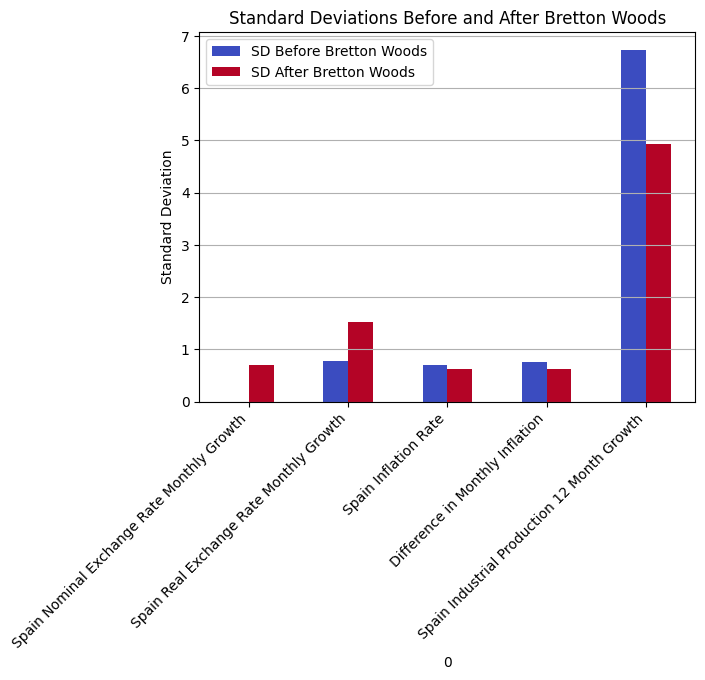

In [11]:
# Plotting the bar chart for Standard Deviations
plt.figure(figsize=(12, 8))
std_table.drop(columns='Ratio (Before/After)').plot(kind='bar', colormap='coolwarm')

# Set the title and labels
plt.title('Standard Deviations Before and After Bretton Woods')
plt.ylabel('Standard Deviation')

# Adjust x-axis labels for better alignment
plt.xticks(rotation=45, ha='right')

# Add gridlines
plt.grid(axis='y')

# Show the legend
plt.legend(loc='upper left')

# Display the plot
plt.show()

We visualise:
* The yearly standard deviation of key economic indicators—Spain's inflation rate.
* The difference in inflation between Spain and the US.
* Spain's 12-month industrial production growth.

We calculate the rolling 12-month standard deviations to observe fluctuations over time. Vertical dashed lines mark the transition from the Bretton Woods system (June 1971) and the start of the post-Bretton Woods period (March 1973).
We aim to analyse changes in economic volatility before and after the shift to a floating exchange rate regime.

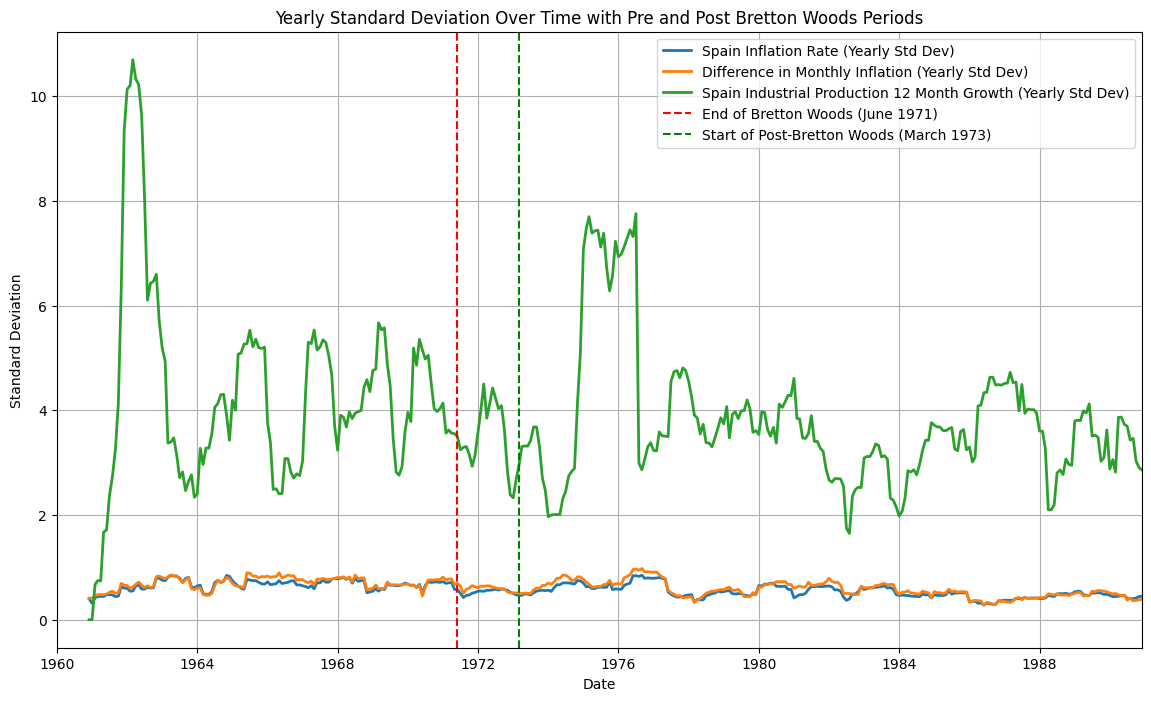

In [12]:
# Variables to plot
variables = [
    'Spain Inflation Rate',
    'Difference in Monthly Inflation',
    'Spain Industrial Production 12 Month Growth'
]

# Calculate the rolling yearly standard deviation (12-month window)
rolling_std = merged_data[variables].rolling(window=12).std()

# Plot the rolling standard deviations
plt.figure(figsize=(14, 8))

for var in variables:
    plt.plot(merged_data['Date'], rolling_std[var], label=f'{var} (Yearly Std Dev)', linewidth=2)

# Highlight the pre- and post-Bretton Woods periods with vertical lines
plt.axvline(x=pd.to_datetime('1971-06-01'), color='red', linestyle='--', label='End of Bretton Woods (June 1971)')
plt.axvline(x=pd.to_datetime('1973-03-01'), color='green', linestyle='--', label='Start of Post-Bretton Woods (March 1973)')

# Add labels and title
plt.title('Yearly Standard Deviation Over Time with Pre and Post Bretton Woods Periods')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')

# Set x-axis limits to ensure both periods are visible
plt.xlim(pd.to_datetime('1960-01-01'), merged_data['Date'].iloc[-1])  # Adjust the end date if necessary

# Add legend
plt.legend(loc='upper right')

# Show grid and the plot
plt.grid(True)
plt.show()

## Section 5.2.4 Regression Analysis ##

### 11: Regression Analysis ###
For every 6-month period (e.g. Jan - Jun and Jul - Dec), we calculate the standard deviation for the
following variables:  
• The monthly growth in the real exchange rate.  
• The inflation difference between your country versus the US.  
• The 12-monthly industrial production growth.


In [13]:
# Extract year and 6-month period (Jan-Jun or Jul-Dec)
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Period'] = merged_data['Date'].dt.month.apply(lambda x: 'Jan-Jun' if x <= 6 else 'Jul-Dec')

# Variables for calculation
variables = [
    'Spain Real Exchange Rate Monthly Growth',
    'Difference in Monthly Inflation',
    'Spain Industrial Production 12 Month Growth'
]

# Group by 'Year' and 'Period', and calculate the standard deviation for each group
std_6_months = merged_data.groupby(['Year', 'Period'])[variables].std()

# Display the results
print(std_6_months)

0             Spain Real Exchange Rate Monthly Growth  \
Year Period                                             
1960 Jan-Jun                                 0.126358   
     Jul-Dec                                 0.423211   
1961 Jan-Jun                                 0.482039   
     Jul-Dec                                 0.750265   
1962 Jan-Jun                                 0.558347   
...                                               ...   
1988 Jul-Dec                                 1.753152   
1989 Jan-Jun                                 0.355244   
     Jul-Dec                                 1.765838   
1990 Jan-Jun                                 1.574261   
     Jul-Dec                                 1.919621   

0             Difference in Monthly Inflation  \
Year Period                                     
1960 Jan-Jun                         0.125663   
     Jul-Dec                         0.425627   
1961 Jan-Jun                         0.480439   
     Jul-Dec 

Manually confirm that code is correct by checking a particular 6-month period for each variable.

In [14]:
# Filter for January to June 1990
start_date = '1990-01-01'
end_date = '1990-06-30'

# Filter the dataset for the 6-month period
period_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]

# Calculate standard deviation manually for each variable
std_real_exchange_rate = period_data['Spain Real Exchange Rate Monthly Growth'].std()
std_inflation_difference = period_data['Difference in Monthly Inflation'].std()
std_industrial_production = period_data['Spain Industrial Production 12 Month Growth'].std()

# Print manual standard deviations
print(f"Manual Standard Deviation (Spain Real Exchange Rate Monthly Growth): {std_real_exchange_rate}")
print(f"Manual Standard Deviation (Difference in Monthly Inflation): {std_inflation_difference}")
print(f"Manual Standard Deviation (Spain Industrial Production 12 Month Growth): {std_industrial_production}")

Manual Standard Deviation (Spain Real Exchange Rate Monthly Growth): 1.5742611056132156
Manual Standard Deviation (Difference in Monthly Inflation): 0.168777646309588
Manual Standard Deviation (Spain Industrial Production 12 Month Growth): 3.925140913963938


Run regressions with the 6-monthly standard deviation of the inflation difference and the 12-monthly
industrial production growth as the dependent variable, and the 6-monthly standard deviation in the
monthly growth of the real exchange rate as the independent variable.

In [15]:
# Dependent variables (Inflation Difference and Industrial Production Growth)
inflation_diff_std = std_6_months['Difference in Monthly Inflation']
industrial_prod_std = std_6_months['Spain Industrial Production 12 Month Growth']

# Independent variable: 6-month rolling standard deviation of the real exchange rate
real_exchange_rate_std = std_6_months['Spain Real Exchange Rate Monthly Growth']

# Add a constant to the independent variable (for the intercept in the regression)
X = sm.add_constant(real_exchange_rate_std)

# Run the regression for inflation difference
model_inflation = sm.OLS(inflation_diff_std, X).fit()

# Run the regression for industrial production growth
model_industrial_prod = sm.OLS(industrial_prod_std, X).fit()

# Print the results of the regressions
print("Regression Results for Inflation Difference:")
print(model_inflation.summary())

print("\nRegression Results for Industrial Production Growth:")
print(model_industrial_prod.summary())

Regression Results for Inflation Difference:
                                   OLS Regression Results                                  
Dep. Variable:     Difference in Monthly Inflation   R-squared:                       0.002
Model:                                         OLS   Adj. R-squared:                 -0.015
Method:                              Least Squares   F-statistic:                    0.1043
Date:                             Sun, 23 Mar 2025   Prob (F-statistic):              0.748
Time:                                     21:02:37   Log-Likelihood:                 9.2884
No. Observations:                               62   AIC:                            -14.58
Df Residuals:                                   60   BIC:                            -10.32
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                   

Show side-by-side graphs with the 6-monthly standard deviation of the monthly growth in the real
exchange rate on the x-axis and the dependent variables on the y-axis. Include both a linear and
second-degree line of best fit, as well as an appropriate title that conveys the key point of your graphs.

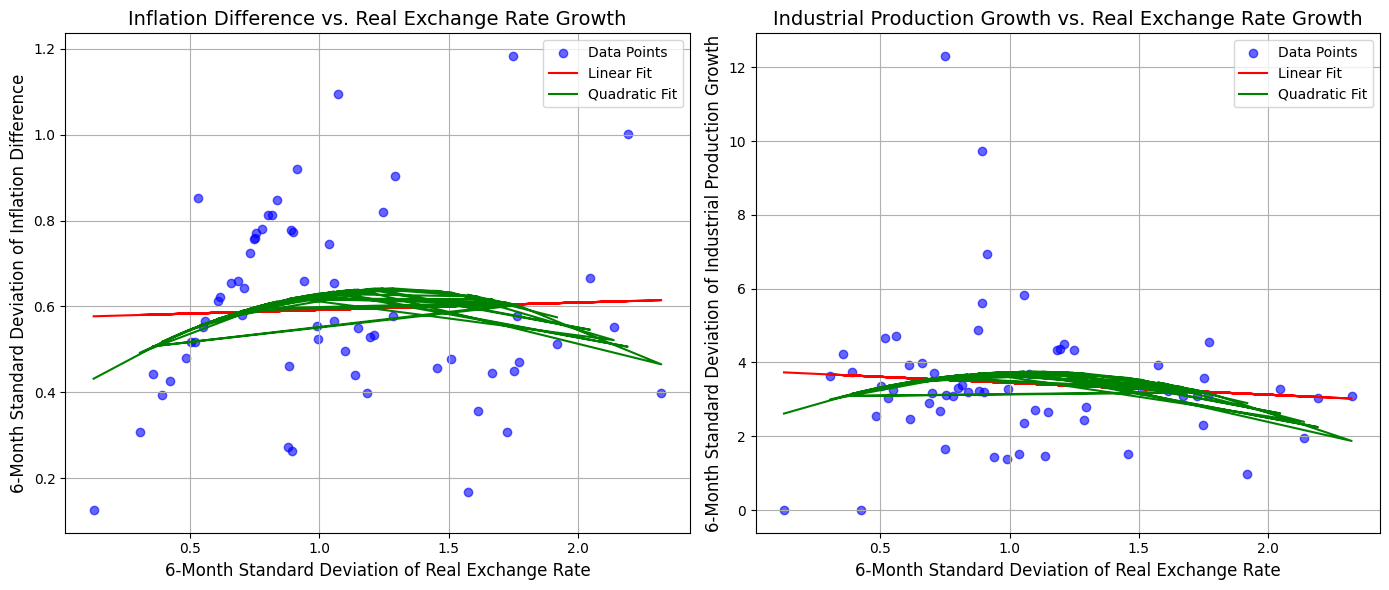

In [16]:
X = std_6_months['Spain Real Exchange Rate Monthly Growth']

# Create the figure and axis for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Inflation Difference Plot ---
# Scatter plot
axes[0].scatter(X, inflation_diff_std, color='blue', alpha=0.6, label='Data Points')

# Linear Regression
X_with_const = sm.add_constant(X)  # Add constant for intercept
model_linear_inflation = sm.OLS(inflation_diff_std, X_with_const).fit()
axes[0].plot(X, model_linear_inflation.predict(X_with_const), color='red', label='Linear Fit')

# Quadratic Regression
X_squared = np.column_stack((X, X**2))
X_with_const_quad = sm.add_constant(X_squared)
model_quad_inflation = sm.OLS(inflation_diff_std, X_with_const_quad).fit()
axes[0].plot(X, model_quad_inflation.predict(X_with_const_quad), color='green', label='Quadratic Fit')

# Formatting the Inflation Difference Plot
axes[0].set_title('Inflation Difference vs. Real Exchange Rate Growth', fontsize=14)
axes[0].set_xlabel('6-Month Standard Deviation of Real Exchange Rate', fontsize=12)
axes[0].set_ylabel('6-Month Standard Deviation of Inflation Difference', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(True)

# --- Industrial Production Growth Plot ---
# Scatter plot
axes[1].scatter(X, industrial_prod_std, color='blue', alpha=0.6, label='Data Points')

# Linear Regression
model_linear_industrial_prod = sm.OLS(industrial_prod_std, X_with_const).fit()
axes[1].plot(X, model_linear_industrial_prod.predict(X_with_const), color='red', label='Linear Fit')

# Quadratic Regression
model_quad_industrial_prod = sm.OLS(industrial_prod_std, X_with_const_quad).fit()
axes[1].plot(X, model_quad_industrial_prod.predict(X_with_const_quad), color='green', label='Quadratic Fit')

# Formatting the Industrial Production Growth Plot
axes[1].set_title('Industrial Production Growth vs. Real Exchange Rate Growth', fontsize=14)
axes[1].set_xlabel('6-Month Standard Deviation of Real Exchange Rate', fontsize=12)
axes[1].set_ylabel('6-Month Standard Deviation of Industrial Production Growth', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

## Section  6.1 Studying Levels vs Volatility ##

### 12:  Studying Levels vs Volatility ###
before_bretton_woods and after_bretton_woods have already been defined under Comparison Statistics & Visualisation

We compare the average values of key economic indicators in Spain before and after the Bretton Woods system:
*  Nominal exchange rate
*  Real exchange rate
*  Inflation rate
*  12-month industrial production growth

We first calculate the mean for each variable in the two periods and then visualise the results using a set of four bar charts.

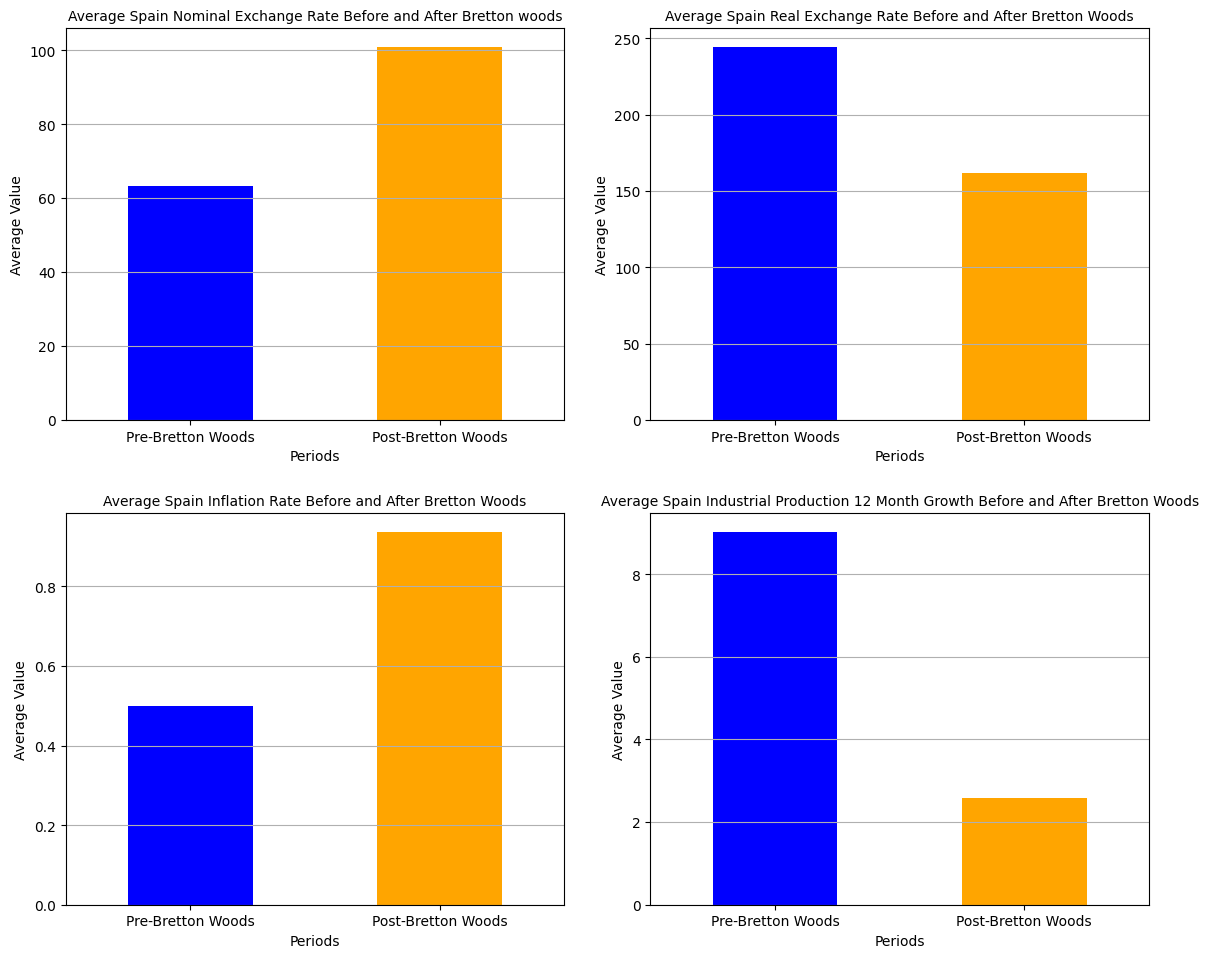

In [17]:
# Calculate the averages for each variable before and after Bretton Woods
avg_before_bretton_woods = before_bretton_woods[['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
                                                'Spain Real Exchange Rate',
                                                'Spain Inflation Rate',
                                                'Spain Industrial Production 12 Month Growth']].mean()

avg_after_bretton_woods = after_bretton_woods[['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
                                               'Spain Real Exchange Rate',
                                               'Spain Inflation Rate',
                                               'Spain Industrial Production 12 Month Growth']].mean()

# Combine the averages for comparison
comparison_df = pd.DataFrame({
    'Pre-Bretton Woods': avg_before_bretton_woods,
    'Post-Bretton Woods': avg_after_bretton_woods
})

# Create subplots: 2 rows and 2 columns (4 plots)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of variables to plot
variables = ['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
             'Spain Real Exchange Rate',
             'Spain Inflation Rate',
             'Spain Industrial Production 12 Month Growth']

# Iterate through the variables and plot on separate subplots
for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]  # Determine the subplot index

    # Change the title for Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate
    if var == 'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate':
        title = 'Average Spain Nominal Exchange Rate Before and After Bretton woods'
    else:
        title = f'Average {var} Before and After Bretton Woods'

    comparison_df.loc[var].plot(kind='bar', ax=ax, color=['blue', 'orange'])
    ax.set_title(title, fontsize=10)  # Use the customized title
    ax.set_ylabel('Average Value')
    ax.set_xlabel('Periods')
    ax.set_xticklabels(['Pre-Bretton Woods', 'Post-Bretton Woods'], rotation=0)
    ax.grid(axis='y')

# Adjust layout to avoid overlap
plt.tight_layout(pad=2.2)

# Show the plot
plt.show()


## Section 6.2 Black Wednesday: The UK Joining & Leaving the ERM ##

### 13: Black Wednesday: The UK Joining & Leaving the ERM ###

Importing Additional data for the UK and Germany from the IMF "International financial statistics"

In [18]:
# Google Sheets URL
uk_url = 'https://docs.google.com/spreadsheets/d/16-AowwgQO0TFYVq-62wggfi7e_8TLD8h/export?format=xlsx'
germany_url = 'https://docs.google.com/spreadsheets/d/10DOsE01ssuRo_jqttaC_NJDBeuVkwmUu/export?format=xlsx'

# Fetch the data
response_uk = requests.get(uk_url)
response_uk.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
response_germany = requests.get(germany_url)
response_germany.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

# Convert to DataFrames
uk_data = pd.read_excel(io.BytesIO(response_uk.content), header=0)
germany_data = pd.read_excel(io.BytesIO(response_germany.content), header=0)

# Merge the UK and Germany datasets into one dataframe
merged_data = pd.merge(uk_data, germany_data, left_index=True, right_index=True, suffixes=('_UK', '_Germany'))

# Drop the country and repeated date column and rename the remaining one
merged_data = merged_data.drop(columns=['Unnamed: 0_UK', 'Unnamed: 0_Germany', 'Unnamed: 1_Germany'])
merged_data = merged_data.rename(columns={'Unnamed: 1_UK': 'Date'})

# Convert all columns except 'Date' to numeric, coercing errors to NaN
merged_data.iloc[:, 1:] = merged_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
merged_data = merged_data.infer_objects()

# Format the month and year variable into a date format
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%b %Y', errors='coerce')

# Display merged data
merged_data.head()


,Date,"Economic Activity, Industrial Production, Index_UK","Exchange Rates, National Currency Per U.S. Dollar, End of Period, Rate_UK","Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate_UK","Monetary and Financial Accounts, Interest Rates, Central Bank Policy Rates, Monetary Policy-Related Interest Rate, Percent per Annum","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_UK","Labor Markets, Unemployment Rate, Percent","Prices, Consumer Price Index, All items, Index_UK","Economic Activity, Industrial Production, Index_Germany","Exchange Rates, National Currency Per U.S. Dollar, End of Period, Rate_Germany","Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate_Germany","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar_Germany","Prices, Consumer Price Index, All items, Index_Germany"
0,1985-01-01,68.252953,0.886918,0.885801,13.875,14686.404136,11.4,45.947538,67.413087,3.1677,3.1677,43515.231728,62.591353
1,1985-02-01,74.929872,0.917431,0.912660,13.875,14298.070901,11.4,46.300203,67.982143,3.3225,3.2921,42160.446630,62.871096
2,1985-03-01,78.639272,0.804505,0.894962,12.875,13788.951232,11.3,46.753638,74.482204,3.0930,3.3092,41586.956975,63.080892
3,1985-04-01,69.458508,0.803665,0.805316,12.375,14278.858630,11.2,47.761254,70.033950,3.0902,3.0830,42325.948653,63.150828
4,1985-05-01,69.087568,0.785238,0.800777,12.375,14260.156688,11.1,47.962782,69.392760,3.0892,3.1139,43260.467954,63.150828


### 14: UK vs Germany Inflation Rate ###


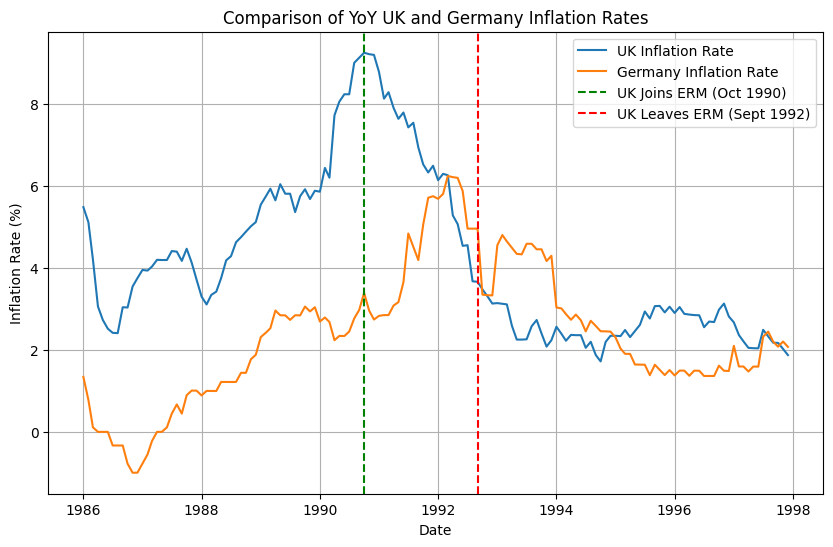

In [19]:
merged_data['YoY_Inflation_UK'] = merged_data['Prices, Consumer Price Index, All items, Index_UK'].pct_change(12) * 100
merged_data['YoY_Inflation_Germany'] = merged_data['Prices, Consumer Price Index, All items, Index_Germany'].pct_change(12) * 100

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['YoY_Inflation_UK'], label='UK Inflation Rate')
plt.plot(merged_data['Date'], merged_data['YoY_Inflation_Germany'], label='Germany Inflation Rate')
plt.grid(True)

# Define the dates when the UK joined and left the ERM
join_erm_date = pd.to_datetime('1990-10-01')  # October 1990
leave_erm_date = pd.to_datetime('1992-09-01')  # September 1992

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Comparison of YoY UK and Germany Inflation Rates')
plt.legend()

# Show the plot
plt.show()

### 15: UK Interest Rates ###

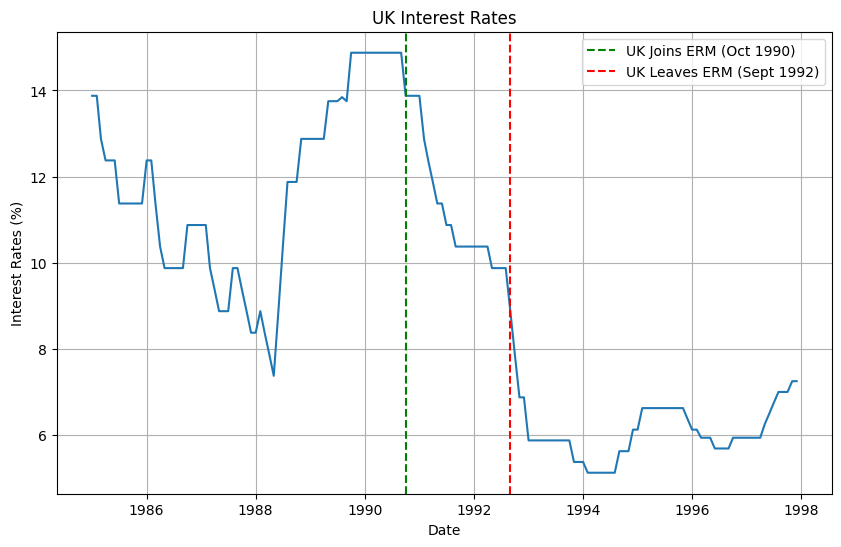

In [20]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Monetary and Financial Accounts, Interest Rates, Central Bank Policy Rates, Monetary Policy-Related Interest Rate, Percent per Annum'])
plt.grid(True)

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rates (%)')
plt.title('UK Interest Rates')
plt.legend()

# Show the plot
plt.show()

### 16: UK Unemployment Rate ###


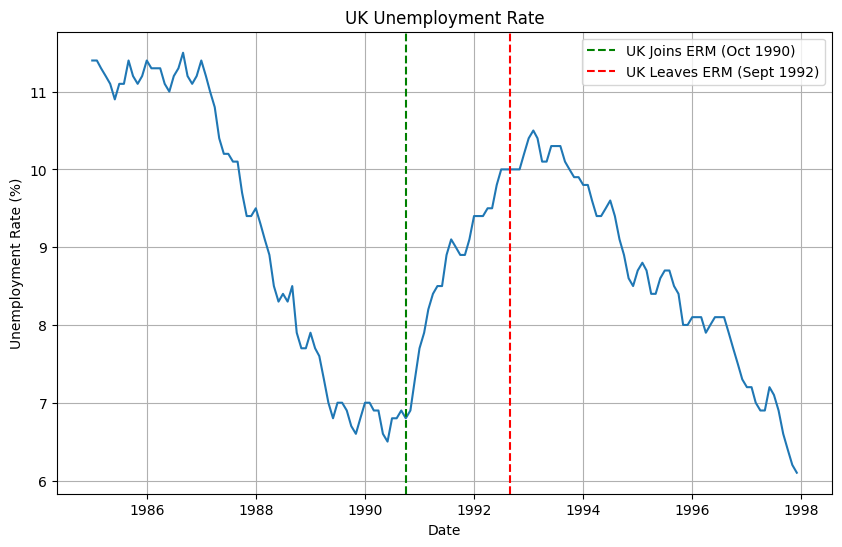

In [21]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Labor Markets, Unemployment Rate, Percent'])
plt.grid(True)

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('UK Unemployment Rate')
plt.legend()

# Show the plot
plt.show()

### 17: UK Industrial Production Growth ##


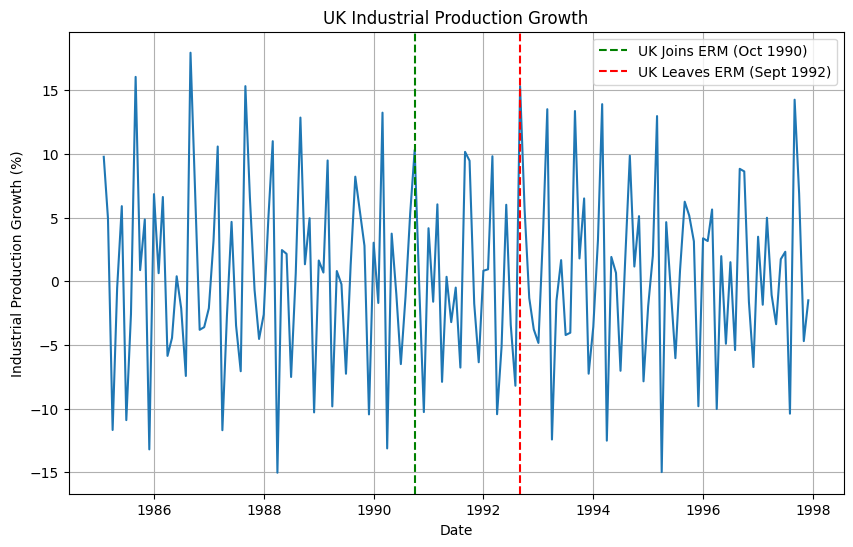

In [22]:
# Monthly growth in industrial production for UK (percentage change)
merged_data['UK Industrial Production Monthly Growth'] = merged_data['Economic Activity, Industrial Production, Index_UK'].pct_change() * 100

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['UK Industrial Production Monthly Growth'])
plt.grid(True)

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Industrial Production Growth (%)')
plt.title('UK Industrial Production Growth')
plt.legend()

# Show the plot
plt.show()


### 18: UK Inflation Difference with Germany ###


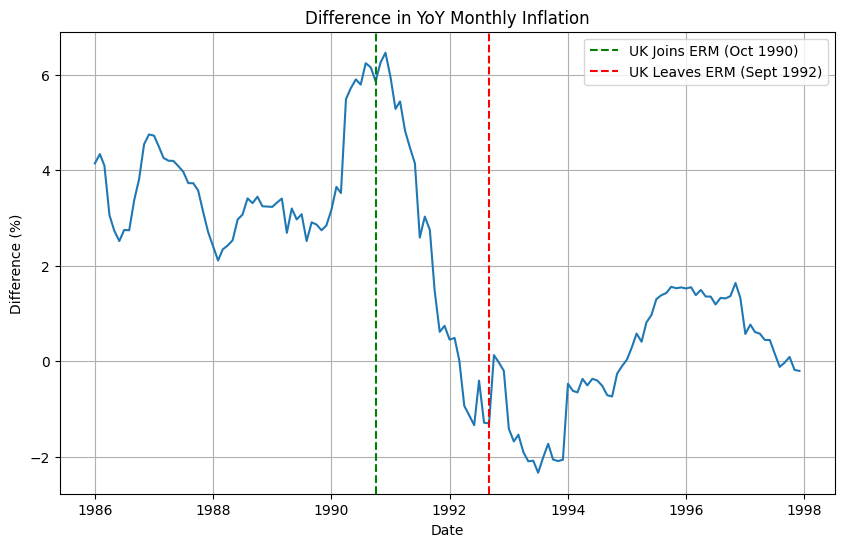

In [23]:
# Monthly difference in inflation for UK and Germany (percentage change)
merged_data['Difference in Monthly Inflation'] = merged_data['YoY_Inflation_UK'] - merged_data['YoY_Inflation_Germany']

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Difference in Monthly Inflation'])
plt.grid(True)

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Difference (%)')
plt.title('Difference in YoY Monthly Inflation')
plt.legend()

# Show the plot
plt.show()


### 19: DM/£ Exchange Rate ###





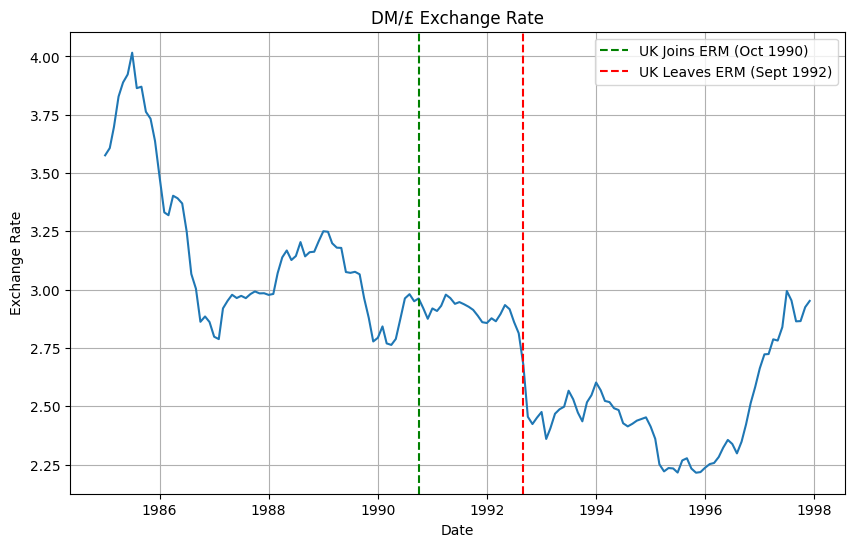

In [24]:
# Exchange rate for  DM/£
merged_data['Exchange Rate'] = merged_data['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate_Germany'] / merged_data['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate_UK']

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Date'], merged_data['Exchange Rate'])
plt.grid(True)

# Add vertical lines for when the UK joined and left the ERM
plt.axvline(x=join_erm_date, color='g', linestyle='--', label='UK Joins ERM (Oct 1990)')
plt.axvline(x=leave_erm_date, color='r', linestyle='--', label='UK Leaves ERM (Sept 1992)')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('DM/£ Exchange Rate')
plt.legend()

# Show the plot
plt.show()


### 20: Volatility Comparison ###

<Figure size 1200x800 with 0 Axes>

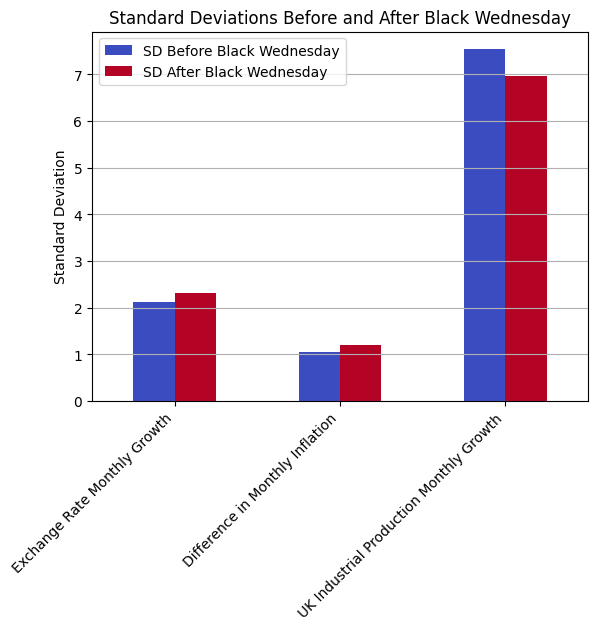

In [26]:
# Filter for Before and After Black Wednesday
before_blackwed = merged_data[merged_data['Date'] <= '1990-10-01']
after_blackwed = merged_data[merged_data['Date'] >= '1992-09-01']

# Variables for Standard Deviation Calculation
variables = [
    'Exchange Rate Monthly Growth',
    'Difference in Monthly Inflation',
    'UK Industrial Production Monthly Growth'
]

# Monthly growth in exchange rate (percentage change)
merged_data['Exchange Rate Monthly Growth'] = merged_data['Exchange Rate'].pct_change() * 100

# Calculate Standard Deviations
std_before = before_blackwed[variables].std()
std_after = after_blackwed[variables].std()

# Calculate Ratios
std_ratio = std_before / std_after

# Combine Results in a DataFrame
std_table = pd.DataFrame({
    'SD Before Black Wednesday': std_before,
    'SD After Black Wednesday': std_after,
})

# Plotting the bar chart for Standard Deviations
plt.figure(figsize=(12, 8))
std_table.plot(kind='bar', colormap='coolwarm')

# Set the title and labels
plt.title('Standard Deviations Before and After Black Wednesday')
plt.ylabel('Standard Deviation')

# Adjust x-axis labels for better alignment
plt.xticks(rotation=45, ha='right')

# Add gridlines
plt.grid(axis='y')

# Show the legend
plt.legend(loc='upper left')

# Display the plot
plt.show()